# 5-fold Cross validation (Do not need to run again)
**The below code is for separating original data (30 pairs of image and labels) to do cross validation.**
**Note that this code run in the local directory instead of colab directory.**
**The data sets in colab was separated already.**

In [0]:
import numpy as np
import skimage.io as io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold
import os

def findAllData():
    alltrain = io.imread("data/images/train-volume00.jpg",as_gray=True)
    alllabel = io.imread("data/labels/train-labels00.jpg",as_gray=True)
    alltrain = np.reshape(alltrain,alltrain.shape+(1,))
    alllabel = np.reshape(alllabel,alllabel.shape+(1,))
    for i in range(1,30):
        eachimg = io.imread("data/images/train-volume"+str(i).zfill(2)+".jpg",as_gray=True)
        eachlabel = io.imread("data/labels/train-labels"+str(i).zfill(2)+".jpg",as_gray=True)
        eachimg = np.reshape(eachimg,eachimg.shape+(1,))
        eachlabel = np.reshape(eachlabel,eachlabel.shape+(1,))
        alltrain = np.concatenate([alltrain,eachimg],axis = -1)
        alllabel = np.concatenate([alllabel,eachlabel],axis = -1)
    print(alltrain.shape)
    print(alllabel.shape)
    return alltrain,alllabel

def makeDir(save_path):
    os.makedirs(save_path+"train/images/")
    os.makedirs(save_path+"train/labels/")
    os.makedirs(save_path+"validation/images/")
    os.makedirs(save_path+"validation/labels/")
    
def writeData(train_img,train_label,val_img,val_label,foldNum):
    save_path = "data/"+str(foldNum)+"_fold/"
    makeDir(save_path)
    for i in range(train_img.shape[2]):
        io.imsave(save_path+"train/images/"+str(i).zfill(2)+".jpg",train_img[:,:,i],quality=100)
        io.imsave(save_path+"train/labels/"+str(i).zfill(2)+".jpg",train_label[:,:,i],quality=100)
    for i in range(val_img.shape[2]):
        io.imsave(save_path+"validation/images/"+str(i).zfill(2)+".jpg",val_img[:,:,i],quality=100)
        io.imsave(save_path+"validation/labels/"+str(i).zfill(2)+".jpg",val_label[:,:,i],quality=100)

def mkSubFold(k):
    alltrain,alllabel = findAllData()
    indices = np.arange(alltrain.shape[2])
    numPairsData = len(indices)
    kf = KFold(n_splits=k,shuffle=True,random_state=1)
    foldNum = 1
    for trainIdx,valIdx in kf.split(indices):
        train_img = alltrain[:,:,trainIdx]
        train_label = alllabel[:,:,trainIdx]
        val_img = alltrain[:,:,valIdx]
        val_label = alllabel[:,:,valIdx]
        writeData(train_img,train_label,val_img,val_label,foldNum)
        foldNum+=1

mkSubFold(5)

# Construct a Network

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet_resnet(input_size = (512,512,1)):
    inputs = Input(shape=input_size)
    
    conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    #Resnet==============
    Iput1 = Conv2D(64, 1, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    Iput1 = BatchNormalization()(Iput1)
    conv1 = Add()([Iput1,conv1])
    conv1 = Activation('relu')(conv1)
    #====================
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    #Resnet==============
    Iput2 = Conv2D(128, 1, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    Iput2 = BatchNormalization()(Iput2)
    conv2 = Add()([Iput2,conv2])
    conv2 = Activation('relu')(conv2)
    #====================
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    #Resnet==============
    Iput3 = Conv2D(256, 1, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    Iput3 = BatchNormalization()(Iput3)
    conv3 = Add()([Iput3,conv3])
    conv3 = Activation('relu')(conv3)
    #====================

    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(drop3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    #Resnet==============
    Iput4 = Conv2D(512, 1, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    Iput4 = BatchNormalization()(Iput4)
    conv4 = Add()([Iput4,conv4])
    conv4 = Activation('relu')(conv4)
    #====================
    
    drop4 = Dropout(0.7)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    #Resnet==============
    Iput5 = Conv2D(1024, 1, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    Iput5 = BatchNormalization()(Iput5)
    conv5 = Add()([Iput5,conv5])
    conv5 = Activation('relu')(conv5)
    #====================
    
    drop5 = Dropout(0.7)(conv5)
    up6 = Conv2D(512, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = BatchNormalization()(up6)
    up6 = Activation('relu')(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    #Resnet==============
    Iput6 = Conv2D(512, 1, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    Iput6 = BatchNormalization()(Iput6)
    conv6 = Add()([Iput6,conv6])
    conv6 = Activation('relu')(conv6)
    #====================
    
    drop6 = Dropout(0.7)(conv6)
    up7 = Conv2D(256, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    up7 = BatchNormalization()(up7)
    up7 = Activation('relu')(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    #Resnet==============
    Iput7 = Conv2D(256, 1, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    Iput7 = BatchNormalization()(Iput7)
    conv7 = Add()([Iput7,conv7])
    conv7 = Activation('relu')(conv7)
    #====================
    
    drop7 = Dropout(0.5)(conv7)
    up8 = Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    up8 = BatchNormalization()(up8)
    up8 = Activation('relu')(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    #Resnet==============
    Iput8 = Conv2D(128, 1, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    Iput8 = BatchNormalization()(Iput8)
    conv8 = Add()([Iput8,conv8])
    conv8 = Activation('relu')(conv8)
    #====================
    
    up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = Activation('relu')(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    #Resnet==============
    Iput9 = Conv2D(64, 1, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    Iput9 = BatchNormalization()(Iput9)
    conv9 = Add()([Iput9,conv9])
    conv9 = Activation('relu')(conv9)
    #====================
    
    conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 2e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model


Using TensorFlow backend.


# Using ImageDataGenerator to do online preprocessing and training

In [0]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans

def trainGenerator(batch_size,train_path,image_folder,label_folder,aug_dict,image_color_mode = "grayscale",
                    label_color_mode = "grayscale",target_size = (512,512),seed = 1):
  
    image_datagen = ImageDataGenerator(**aug_dict)
    label_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    label_generator = label_datagen.flow_from_directory(
        train_path,
        classes = [label_folder],
        class_mode = None,
        color_mode = label_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    train_generator = zip(image_generator, label_generator)
    for (img,label) in train_generator:
        if np.max(img)>1:
            img = img / 255
            label = label /255
            label[label > 0.5] = 1
            label[label <= 0.5] = 0
        yield (img,label)


# Set parameters of ImageDataGenerator and generate two generator objects for training and validation with different random seed. 

In [0]:

data_gen_args = dict(rotation_range=90,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
trainGene = trainGenerator(2,'drive/My Drive/9517project/data/1_fold/train','images','labels',data_gen_args,seed = 1)
validGene = trainGenerator(1,'drive/My Drive/9517project/data/1_fold/validation','images','labels',data_gen_args,seed = 5)

model = unet_resnet()


W0805 12:39:02.230068 140287282476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 12:39:02.285039 140287282476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 12:39:02.294245 140287282476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0805 12:39:02.343293 140287282476928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 12:39:02.344619

# Use ModelCheckpoint to store the best weight during training process 
# and draw performance by pyplot.

Epoch 1/10
Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
1000/1000 [==============================] - 1939s 2s/step - loss: 0.4542 - acc: 0.7919 - val_loss: 0.3906 - val_acc: 0.7952

Epoch 00001: val_loss improved from inf to 0.39062, saving model to drive/My Drive/data/1_fold/unet_resnet_1.h5
Epoch 2/10
1000/1000 [==============================] - 1905s 2s/step - loss: 0.3516 - acc: 0.7916 - val_loss: 0.3163 - val_acc: 0.7958

Epoch 00002: val_loss improved from 0.39062 to 0.31629, saving model to drive/My Drive/data/1_fold/unet_resnet_1.h5
Epoch 3/10
1000/1000 [==============================] - 1904s 2s/step - loss: 0.3001 - acc: 0.7916 - val_loss: 0.2889 - val_acc: 0.7971

Epoch 00003: val_loss improved from 0.31629 to 0.28894, saving model to drive/My Drive/data/1_fold/unet_resnet_1.h5
Epoch 4/10
1000/1000 [==============================] - 1904s 2s/step - loss: 0.2660 - 

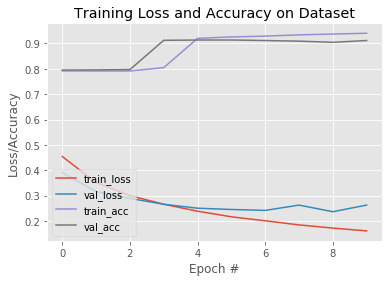

In [0]:
import matplotlib.pyplot as plt

checkpoint = ModelCheckpoint("drive/My Drive/9517project/data/1_fold/unet_resnet_1.h5", monitor='val_loss', \
                             verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
his=model.fit_generator(generator = trainGene,steps_per_epoch=1000,epochs=10,
                        validation_data = validGene, validation_steps=100,callbacks = [checkpoint],class_weight='auto')
model.save("drive/My Drive/9517project/data/1_fold/unet_resnet_1.h5")
print("Saved model to disk")

N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), his.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), his.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), his.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), his.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("drive/My Drive/9517project/data/1_fold/Information.png")

print("done!!!!!")

# Test performance of model using original 30 gray images,
# and then save prediction labels.

In [0]:
def testGenerator(test_path,num_image = 30,target_size = (512,512),as_gray = True):
    for i in range(num_image):
        img = io.imread(test_path+"/train-volume"+str(i).zfill(2)+".jpg",as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,(1,)+img.shape+(1,))
        yield img

In [0]:
mymodel = load_model("drive/My Drive/9517project/data/1_fold/unet_resnet_1.h5")
testGene = testGenerator("drive/My Drive/9517project/data/images")
results = mymodel.predict_generator(testGene,30,verbose=1)


W0805 23:07:25.736199 140160257640320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 23:07:25.796348 140160257640320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0805 23:07:25.867319 140160257640320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 23:07:25.877701 140160257640320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 23:07:25.89407

30/30 [==============================] - 22s 730ms/step


In [0]:
# from tifffile import imsave
def saveResult(save_path,npyfile):
    for i,item in enumerate(npyfile):
        im_np = item[:,:]
        io.imsave(save_path+str(i).zfill(2)+".jpg",im_np,quality=100)

saveResult("drive/My Drive/9517project/data/1_fold/",results)


W0805 23:09:14.979774 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0805 23:09:15.001000 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0805 23:09:15.024304 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0805 23:09:15.044713 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0805 23:09:15.082527 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0805 23:09:15.106632 140160257640320 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 